# Exploring Text Datasets

Large text datasets are often difficult to grasp, because it is hard to see the big picture when reading many individual texts. In this notebook, we create an interactive visualization of paragraphs from Wikipedia articles to show that exploring text datasets this way is much more fun and gives us a better overview of the data.
The original data is from [here](https://rajpurkar.github.io/SQuAD-explorer/) and was modified for our purposes.

Have a look at the file `articles_short.json` in the data folder. The file extension `.json` stands for _JavaScript Object Notation_ and this is a common format for exchanging data online, e.g., when using third-party API services. Conveniently, this data format can be mapped 1:1 to Python data structures (i.e., nested lists and dictionaries). In our case, the file `articles_short.json` contains the texts of 100 Wikipedia articles, which are organized in a dictionary, where the key of the dict is the title of an article and the corresponding value is a list with the individual paragraphs.

In [47]:
# import some libraries that you'll need later
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import plotly.express as px

## Load the data

In [48]:
# load data -> json is parsed as Python data structure
with open("../data/articles_short.json") as f:
    articles = json.load(f)

In [49]:
# check the first element in the dictionary
print("first key:", list(articles.keys())[0])
articles[list(articles.keys())[0]]

first key: Asphalt


['-- BEGIN DOCUMENT --',
 'Asphalt/bitumen also occurs in unconsolidated sandstones known as "oil sands" in Alberta, Canada, and the similar "tar sands" in Utah, US. The Canadian province of Alberta has most of the world\'s reserves of natural bitumen, in three huge deposits covering 142,000 square kilometres (55,000 sq mi), an area larger than England or New York state. These bituminous sands contain 166 billion barrels (26.4×10^9 m3) of commercially established oil reserves, giving Canada the third largest oil reserves in the world. and produce over 2.3 million barrels per day (370×10^3 m3/d) of heavy crude oil and synthetic crude oil. Although historically it was used without refining to pave roads, nearly all of the bitumen is now used as raw material for oil refineries in Canada and the United States.',
 'The first use of asphalt/bitumen in the New World was by indigenous peoples. On the west coast, as early as the 13th century, the Tongva, Luiseño and Chumash peoples collected th

In [50]:
# extract all paragraphs with a list comprehension
# for every article key "a" in the dictionary,
# you get the corresponding list of paragraphs with articles[a]
# then take all of these paragraphs from all articles to form a long list
# (have a look at the Python tutorial if this is new to you)
paragraphs_corpus = [p for a in articles for p in articles[a]]
print(f"Our dataset contains {len(paragraphs_corpus)} paragraphs")

Our dataset contains 4492 paragraphs


In [51]:
# raw data: Wikipedia article paragraphs, i.e. 1 data point = 1 paragraph
paragraphs_corpus[:3]

['-- BEGIN DOCUMENT --',
 'Asphalt/bitumen also occurs in unconsolidated sandstones known as "oil sands" in Alberta, Canada, and the similar "tar sands" in Utah, US. The Canadian province of Alberta has most of the world\'s reserves of natural bitumen, in three huge deposits covering 142,000 square kilometres (55,000 sq mi), an area larger than England or New York state. These bituminous sands contain 166 billion barrels (26.4×10^9 m3) of commercially established oil reserves, giving Canada the third largest oil reserves in the world. and produce over 2.3 million barrels per day (370×10^3 m3/d) of heavy crude oil and synthetic crude oil. Although historically it was used without refining to pave roads, nearly all of the bitumen is now used as raw material for oil refineries in Canada and the United States.',
 'The first use of asphalt/bitumen in the New World was by indigenous peoples. On the west coast, as early as the 13th century, the Tongva, Luiseño and Chumash peoples collected th

## Transform into Tf-Idf Features

In [52]:
# transform the raw texts into features
vectorizer = TfidfVectorizer(strip_accents='unicode')  # strip_accents to use ascii
# fit: check vocab of corpus (i.e. dimensionality of bag-of-words vector) & compute IDF weights
# transform: compute vector for each document (i.e., count TF and multiply by IDF)
X = vectorizer.fit_transform(paragraphs_corpus)
print("Dimensionality of our data:", X.shape)  # number of paragraphs x number of words

Dimensionality of our data: (4492, 34258)


In [53]:
# notice how this is not a normal numpy array, but a scipy sparse matrix
# this is a more efficient way of storing data that contains a lot of 0 values
# by only remembering the indices where the matrix contains non-zero values and what these values are
# (since each individual paragraph contains only very few unique words, this makes a lot of sense here)
# (BUT: not all of the algorithms in sklearn can directly work with this type data, e.g., t-SNE!)
X

<4492x34258 sparse matrix of type '<class 'numpy.float64'>'
	with 333429 stored elements in Compressed Sparse Row format>

## Visualize dataset in 2D 

### ... with Kernel PCA

As you've seen above, our feature matrix $X$ contains many more features (i.e., number of unique words in our corpus, 34258) than data points (i.e., paragraphs, 4492). If we were to compute regular PCA, this would mean we need to compute the eigendecomposition of a $34258 \times 34258$ covariance matrix - you don't want to do this on your laptop! Instead, we can use Kernel PCA, which gives us the same result (if we specify `kernel='linear'`), but computes the eigendecomposition of the similarity matrix, which is only $4492 \times 4492$.

In [54]:
# reduce dimensionality with linear kPCA
# since TF-IDF vectors are length (L2) normalized, the linear kernel = cosine similaritiy
# --> we use 100 components since we feed the reduced data to t-SNE later (-> not sparse)!
kpca = KernelPCA(n_components=100, kernel='linear')
X_kpca = kpca.fit_transform(X)
print("Dimensionality of our data:", X_kpca.shape)

Dimensionality of our data: (4492, 100)


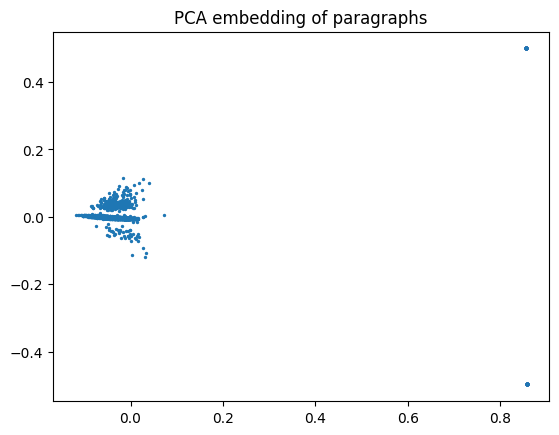

In [55]:
# plot 2D PCA visualization
# the components are ordered by their eigenvalue (largest first), i.e.,
# by taking the first 2 this is the same as if we had computed PCA with n_components=2
plt.figure()
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], s=2)  # s: size of the dots
plt.title("PCA embedding of paragraphs");
# each dot is one paragraph, represented in 2D

In [56]:
# generate color codes for the plot based on the article titles (-> key in the dict)
paragraphs_label = [a for a in articles for p in articles[a]]  # article title for each paragraph
print(len(paragraphs_label))  # same as len(paragraphs_corpus)
print(paragraphs_label[:3])
# map the list of strings to numbers (which we can then use in plt.scatter())
p_labels_num = LabelEncoder().fit_transform(paragraphs_label)
print(len(p_labels_num))
print(p_labels_num[:3])

4492
['Asphalt', 'Asphalt', 'Asphalt']
4492
[4 4 4]


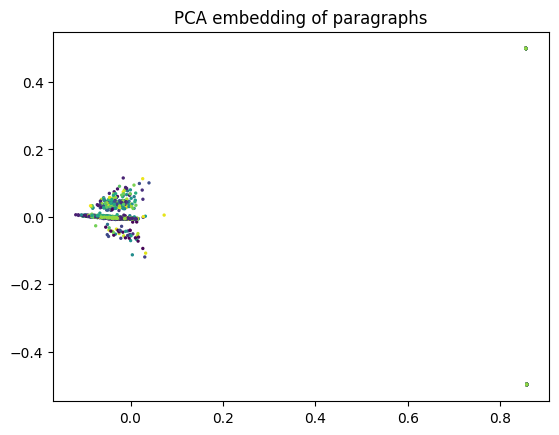

In [57]:
# same plot as above but with colors
plt.figure()
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=p_labels_num, s=2)  # c: list/array of same length as x/y
plt.title("PCA embedding of paragraphs");
# -> paragraph-dots with the same color belong to the same article

In [58]:
# interactive plot with plotly (make sure you're not using Internet Explorer but a modern browser!)
# generate the tooltip text: split texts into lines
hover_texts = ["<b>" + paragraphs_label[i] + "</b><br>" + "<br>".join([" ".join(p.split()[i:min(i+7, len(p.split()))]) for i in range(0, len(p.split()), 7)]) for i, p in enumerate(paragraphs_corpus)]
# create interactive plot and display
fig = px.scatter(x=X_kpca[:, 0], y=X_kpca[:, 1], color=p_labels_num, hover_name=hover_texts)
fig.update_traces(hovertemplate='%{hovertext}')  # only show our text, no additional info
# move your mouse over the dots to see what paragraphs are behind them (first line in bold is the article title)
fig

As you can see, the two dots on the top and bottom right are very different from the rest of the paragraphs, i.e., they could be considered outliers and strongly influence the first two components (these are actually not two individual dots, but many on top of each other as all articles start and end with these lines).

This means the first principle component here captured whether the paragraph consisted of only `DOCUMENT` plus one additional word, while the second component captured whether this additional word was `BEGIN` or `END`. (The other dimensions then contain additional variance introduced by the fact that the dataset includes paragraphs about different topics.) 

This plot therefore tells us that we should probably clean up our dataset a bit by removing these beginning and end phrases before doing any other analysis on this dataset. But before we do that, let's look at the eigenvalue spectrum of the dataset:

[155.12785429  50.27411966  30.24858714  21.12782013  17.50771573
  14.15013134  12.77444433  12.19282836  11.86198603  11.6064332 ]
Percentage of variance retained with 20 components: 49.10306275492285


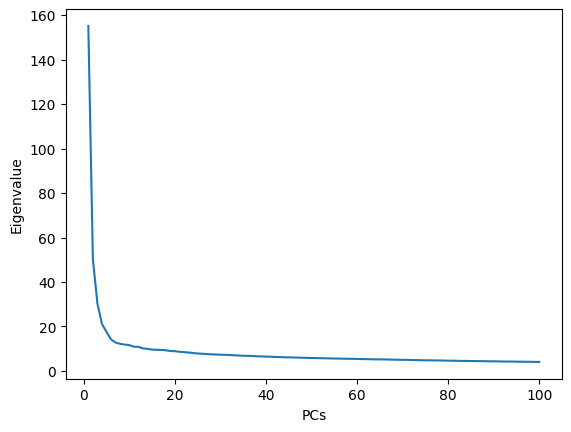

In [59]:
print(kpca.eigenvalues_[:10])
# check how much "information" we would keep if we were to reduce the dimensionality to 20
# (this is not 100% accurate, since we only computed the first 100 kPCA components, i.e.,
# normally kpca.eigenvalues_ should contain all eigenvalues - but this should be close enough)
print("Percentage of variance retained with 20 components:", 100*(sum(kpca.eigenvalues_[:20])/sum(kpca.eigenvalues_)))
# plot eigenvalue spectrum
plt.figure()
plt.plot(range(1, len(kpca.eigenvalues_)+1), kpca.eigenvalues_)
plt.xlabel("PCs")
plt.ylabel("Eigenvalue");
# observe how the first value is extremely large

### Task 1: remove outliers and compute Kernel PCA again

1. Remove the `BEGIN DOCUMENT` and `END DOCUMENT` "paragraphs" from the dataset, i.e., the first and last elements of the list of paragraphs for each article. You can accomplish this by indexing the list of paragraphs of an article with `[1:-1]` to take only the second until the second-to-last elements.
2. Transform this new list of paragraphs into TF-IDF vectors again
3. Compute KernelPCA like before and plot the scatter plot (with colors) again
4. Look at the eigenvalue spectrum again - what do you observe?

In [60]:
# remove outliers (i.e., first and last "paragraph" for each article)
paragraphs_corpus_clean = [p for a in articles for p in articles[a][1:-1]]

In [64]:
# transform list of paragraphs into TF-IDF vectors again

vectorizer_clean = TfidfVectorizer(strip_accents='unicode')

X_clean = vectorizer.fit_transform(paragraphs_corpus_clean)

print("Dimensionality of original data:", X.shape)
print("Dimensionality of clean data:", X_clean.shape)  # (4292, 34258) -> compare to the original size of X

Dimensionality of original data: (4492, 34258)
Dimensionality of clean data: (4292, 34258)


In [66]:
# compute kPCA again (with same parameter settings as before)
X_kpca_clean = kpca.fit_transform(X_clean)

print("Dimensionality of original data:", X_kpca.shape)
print("Dimensionality of clean data:", X_kpca_clean.shape)

Dimensionality of original data: (4492, 100)
Dimensionality of clean data: (4292, 100)


In [67]:
# scatter plot without outliers (with color! but remember, 
# the dimensionality of the color vector needs to match the x/y coordinates)

paragraphs_label_clean = [a for a in articles for p in articles[a][1:-1]]  # article title for each paragraph
print(len(paragraphs_label_clean))  # same as len(paragraphs_corpus)
print(paragraphs_label_clean[:3])

p_labels_num_clean = LabelEncoder().fit_transform(paragraphs_label_clean)
print(len(p_labels_num_clean))
print(p_labels_num_clean[:3])

hover_texts_clean = ["<b>" + paragraphs_label_clean[i] + "</b><br>" + "<br>".join([" ".join(p.split()[i:min(i+7, len(p.split()))]) for i in range(0, len(p.split()), 7)]) for i, p in enumerate(paragraphs_corpus_clean)]
# create interactive plot and display
fig = px.scatter(x=X_kpca_clean[:, 0], y=X_kpca_clean[:, 1], color=p_labels_num_clean, hover_name=hover_texts_clean)
fig.update_traces(hovertemplate='%{hovertext}')  # only show our text, no additional info
# move your mouse over the dots to see what paragraphs are behind them (first line in bold is the article title)
fig

4292
['Asphalt', 'Asphalt', 'Asphalt']
4292
[4 4 4]


In [ ]:
# check eigenvalue spectrum of kPCA again
...

### Task 2: Visualize dataset with t-SNE

1. After you've computed your new kPCA embedding (without outliers), use the code below to compute a t-SNE embedding
2. Then create a regular (matplotlib) and an interactive (plotly) scatter plot of the results again and explore

Notice how the paragraphs form localized clusters (while remembering that this is not a clustering algorithm, but gives us 2D coordinates, not a cluster index, for each data point ;-)). If the task was now to classify the paragraphs (e.g., identify the correct article title for each paragraph), you could see for which articles this would be easy, and where there is overlap between the content of other articles (and you can see how these "mistakes", i.e., where a paragraph is located near the paragraphs of another article, are quite understandable, i.e., a human might have made some of these mistakes as well).

In [ ]:
# use 100D kPCA embedding, since t-SNE can't handle sparse matrices
# (we use the "cosine" metric here since this works well for text,
# for other data you can leave this argument at its default value)
tsne = TSNE(metric="cosine", verbose=2, random_state=42)
X_tsne = tsne.fit_transform(X_kpca)
print("Dimensionality of our data:", X_tsne.shape)

In [ ]:
# plot 2D t-SNE visualization with matplotlib (with colors!)
...

In [ ]:
# new hover_texts since you have less paragraphs
hover_texts = ["<b>" + paragraphs_label[i] + "</b><br>" + "<br>".join([" ".join(p.split()[i:min(i+7, len(p.split()))]) for i in range(0, len(p.split()), 7)]) for i, p in enumerate(paragraphs_corpus)]
# create interactive plot and display
...